In [45]:
# Image sizes

### LOW

# width = 640
# height = 480

### HD

# width = 1920
# height = 1080

### 2K

width = 2592
height = 1944

# Bit depth (e.g. 8bpp, 10bpp, 12bpp, 14bpp, 16bpp)
bpp = 8
# bpp = 16

# Number of images to read
n_images = 1



In [46]:
import shutil, os

# Empty the raw_images and dng_images directories
if os.path.exists('raw_images'):
    shutil.rmtree('raw_images')

if os.path.exists('dng_images'):
    shutil.rmtree('dng_images')

os.mkdir('raw_images')
os.mkdir('dng_images')


In [47]:
# import subprocess
# Not working
# basedir = '/home/pi/cookpad/repo/cookpad-moment'
# subprocess.call(f'scp root@192.168.4.2:/home/root/outputs {os.path.join(basedir,'notebooks/stm32/')}' )

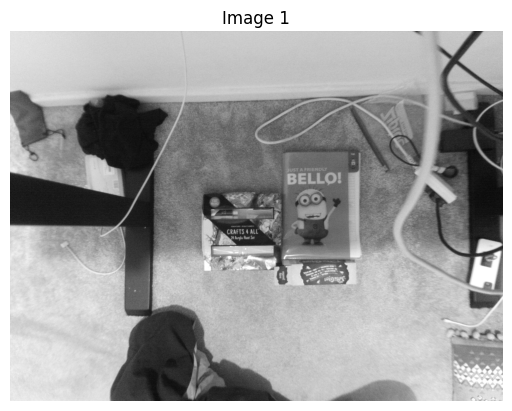

In [52]:
import numpy as np
import matplotlib.pyplot as plt

image_size = width * height * bpp // 8 # 2 bytes per pixel

filename = 'capture01.raw'

with open(filename, 'rb') as f:
    for i in range(n_images):

        raw_data = f.read(image_size)
        if not raw_data:
            print(f"Reached the end of the file at image {i+1}.")
            break
        
        if bpp == 8:
            image = np.frombuffer(raw_data, dtype=np.uint8)
        elif bpp == 16:
            image = np.frombuffer(raw_data, dtype=np.uint16)
        else:
            raise NotImplemented("Only 8bpp and 16bpp are supported.")

        image = image.reshape((height, width))

        # Save raw images
        with open(os.path.join('raw_images', f"raw_{i+1}.raw"), 'wb') as g:
            g.write(raw_data)

        plt.imshow(image, cmap='gray')
        plt.title(f"Image {i+1}")
        plt.axis('off')
        plt.show()


In [53]:
image.min()

np.uint8(4)

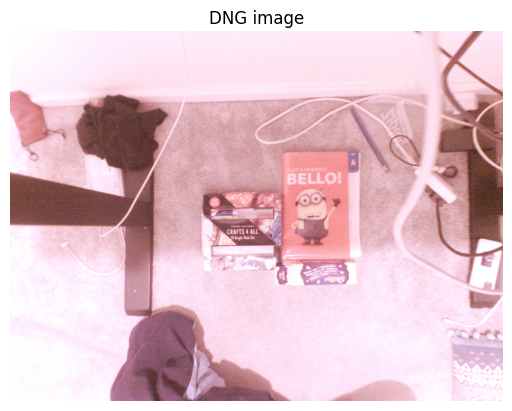

In [54]:
import os
import numpy as np
# from pydng.core import RPICAM2DNG
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *
import struct

import rawpy

# Uncomment to zoom & pan within image:
# %matplotlib widget

# Configuration
bayer_pattern = CFAPattern.BGGR
iso_gain = 100
exposure_time = 20e3  # microseconds
numPixels = width*height

for i in range(n_images):

    rawFile = os.path.join('raw_images', f"raw_{i+1}.raw")
    rf = open(rawFile, mode='rb')

    if bpp == 8:
        rawData = struct.unpack("B"*numPixels,rf.read(numPixels))
    elif bpp == 16:
        rawData = struct.unpack("H"*numPixels,rf.read(2*numPixels))
    else:
        raise NotImplemented("Only 8bpp and 16bpp are supported.")

    rawFlatImage = np.zeros(numPixels, dtype=np.uint16)
    rawFlatImage[:] = rawData[:] 

    if bpp == 16:
        rawFlatImage = rawFlatImage >> (16 - bpp)
        # rawImage = rawImage >> (16 - bpp)

    rawImage = np.reshape(rawFlatImage,(height,width))

    #TODO: validate this is ballpark correct. Got from PyDNG demo
    ccm1 = [[19549, 10000], [-7877, 10000], [-2582, 10000],	
            [-5724, 10000], [10121, 10000], [1917, 10000],
            [-1267, 10000], [ -110, 10000], [ 6621, 10000]]

    # set DNG tags.
    t = DNGTags()
    t.set(Tag.ImageWidth, width)
    t.set(Tag.ImageLength, height)
    t.set(Tag.TileWidth, width)
    t.set(Tag.TileLength, height)
    t.set(Tag.Orientation, Orientation.Horizontal)
    t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
    t.set(Tag.SamplesPerPixel, 1)
    t.set(Tag.BitsPerSample, bpp)
    t.set(Tag.CFARepeatPatternDim, [2,2])
    t.set(Tag.CFAPattern, bayer_pattern)

    #TODO: Are these calculations correct for both 8bpp and 16bpp?
    # t.set(Tag.BlackLevel, (4096 >> (16 - bpp)))
    # Our actual black level is 4 at 8 bpp
    t.set(Tag.BlackLevel, (4 << (bpp-8)))
    t.set(Tag.WhiteLevel, ((1 << bpp) -1) )

    t.set(Tag.ColorMatrix1, ccm1)
    t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65)
    t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]])
    t.set(Tag.BaselineExposure, [[-150,100]])
    t.set(Tag.Make, "OmniVision")
    t.set(Tag.Model, "OV5640")
    t.set(Tag.DNGVersion, DNGVersion.V1_4)
    t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
    t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

    # save to dng file.
    r = RAW2DNG()
    r.options(t, path='dng_images', compress=False)
    r.convert(rawImage, filename=f"dng_{i+1}.dng")

    # Display only last image:
    if i != n_images - 1:
        continue
        
    with rawpy.imread(os.path.join('dng_images', f'dng_{i+1}.dng')) as raw:

        # Demosaic the image
        rgb_base = raw.postprocess()

        # Plot the post correction flat-field image
        plt.figure()
        plt.imshow(rgb_base)
        plt.axis('off')
        plt.title('DNG image')
        plt.show()

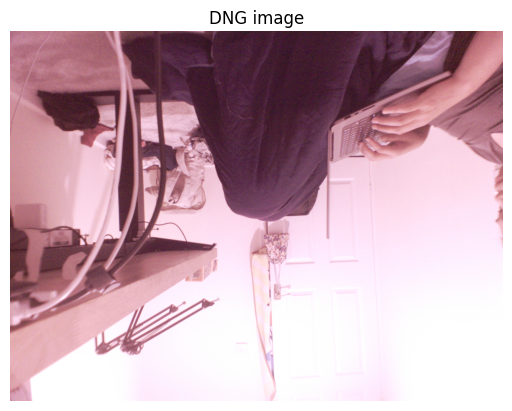

In [55]:
import os
import numpy as np
# from pydng.core import RPICAM2DNG
from pidng.core import RAW2DNG, DNGTags, Tag
from pidng.defs import *
import struct

import rawpy

for i in range(n_images):

    rawFile = os.path.join('capture.raw')
    rf = open(rawFile, mode='rb')

    if bpp == 8:
        rawData = struct.unpack("B"*numPixels,rf.read(numPixels))
    elif bpp == 16:
        rawData = struct.unpack("H"*numPixels,rf.read(2*numPixels))
    else:
        raise NotImplemented("Only 8bpp and 16bpp are supported.")

    rawFlatImage = np.zeros(numPixels, dtype=np.uint16)
    rawFlatImage[:] = rawData[:] 

    if bpp == 16:
        rawFlatImage = rawFlatImage >> (16 - bpp)
        # rawImage = rawImage >> (16 - bpp)

    rawImage = np.reshape(rawFlatImage,(height,width))

    #TODO: validate this is ballpark correct. Got from PyDNG demo
    ccm1 = [[19549, 10000], [-7877, 10000], [-2582, 10000],	
            [-5724, 10000], [10121, 10000], [1917, 10000],
            [-1267, 10000], [ -110, 10000], [ 6621, 10000]]

    # set DNG tags.
    t = DNGTags()
    t.set(Tag.ImageWidth, width)
    t.set(Tag.ImageLength, height)
    t.set(Tag.TileWidth, width)
    t.set(Tag.TileLength, height)
    t.set(Tag.Orientation, Orientation.Horizontal)
    t.set(Tag.PhotometricInterpretation, PhotometricInterpretation.Color_Filter_Array)
    t.set(Tag.SamplesPerPixel, 1)
    t.set(Tag.BitsPerSample, bpp)
    t.set(Tag.CFARepeatPatternDim, [2,2])
    t.set(Tag.CFAPattern, bayer_pattern)

    #TODO: Are these calculations correct for both 8bpp and 16bpp?
    # t.set(Tag.BlackLevel, (4096 >> (16 - bpp)))
    # Our actual black level is 4 at 8 bpp
    t.set(Tag.BlackLevel, (4 << (bpp-8)))
    t.set(Tag.WhiteLevel, ((1 << bpp) -1) )

    t.set(Tag.ColorMatrix1, ccm1)
    t.set(Tag.CalibrationIlluminant1, CalibrationIlluminant.D65)
    t.set(Tag.AsShotNeutral, [[1,1],[1,1],[1,1]])
    t.set(Tag.BaselineExposure, [[-150,100]])
    t.set(Tag.Make, "OmniVision")
    t.set(Tag.Model, "OV5640")
    t.set(Tag.DNGVersion, DNGVersion.V1_4)
    t.set(Tag.DNGBackwardVersion, DNGVersion.V1_2)
    t.set(Tag.PreviewColorSpace, PreviewColorSpace.sRGB)

    # save to dng file.
    r = RAW2DNG()
    r.options(t, path='dng_images', compress=False)
    r.convert(rawImage, filename=f"dng_{i+1}.dng")

    # Display only last image:
    if i != n_images - 1:
        continue
        
    with rawpy.imread(os.path.join('dng_images', f'dng_{i+1}.dng')) as raw:

        # Demosaic the image
        rgb_base = raw.postprocess()

        # Plot the post correction flat-field image
        plt.figure()
        plt.imshow(rgb_base)
        plt.axis('off')
        plt.title('DNG image')
        plt.show()

In [34]:
dir(raw)

['__class__',
 '__delattr__',
 '__dir__',
 '__doc__',
 '__enter__',
 '__eq__',
 '__exit__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__getstate__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__ne__',
 '__new__',
 '__pyx_vtable__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__setstate__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 'black_level_per_channel',
 'camera_white_level_per_channel',
 'camera_whitebalance',
 'close',
 'color_desc',
 'color_matrix',
 'daylight_whitebalance',
 'dcraw_make_mem_image',
 'dcraw_make_mem_thumb',
 'dcraw_process',
 'extract_thumb',
 'num_colors',
 'open_buffer',
 'open_file',
 'postprocess',
 'raw_color',
 'raw_colors',
 'raw_colors_visible',
 'raw_image',
 'raw_image_visible',
 'raw_pattern',
 'raw_type',
 'raw_value',
 'raw_value_visible',
 'rgb_xyz_matrix',
 'sizes',
 'tone_curve',
 'unpack',
 'unpack_thumb',
 'white_level']

In [35]:
raw.raw_image

RuntimeError: unsupported raw data

/var/folders/gh/mr5x1nx12rl1vkzgdrm5bh4r0000gn/T/ipykernel_45072/625751513.py:3: RuntimeWarning: divide by zero encountered in divide
  plt.imshow(rgb_base[:,:,0] / rgb_base[:,:,1], vmin=0.8, vmax=1.2);
/var/folders/gh/mr5x1nx12rl1vkzgdrm5bh4r0000gn/T/ipykernel_45072/625751513.py:3: RuntimeWarning: invalid value encountered in divide
  plt.imshow(rgb_base[:,:,0] / rgb_base[:,:,1], vmin=0.8, vmax=1.2);


NameError: name 'mfr' is not defined

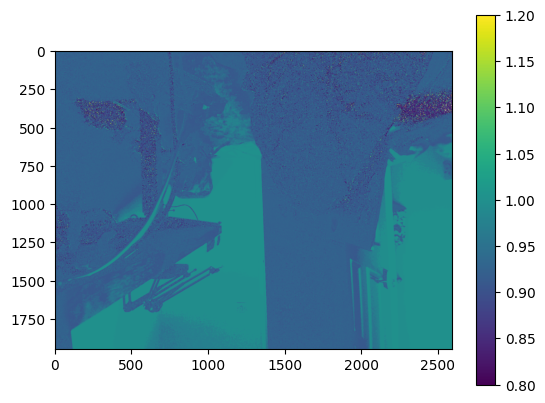

In [36]:
# Show r/g ratio
plt.figure();
plt.imshow(rgb_base[:,:,0] / rgb_base[:,:,1], vmin=0.8, vmax=1.2);
plt.colorbar();
# Run the end cell before this in order for these to be correct:
plt.title(f'Red / Green Ratio, Vendor: {mfr} FOV: {FOV}');

In [ ]:
# # Move images to proper place:

# Keep commented until use to avoid overwriting stuff

import shutil
import os

basedir = '/home/pi/cookpad/repo/cookpad-moment'
outdir = '/home/pi/cookpad/OV-module-tests'
mfr = 'Donguang_Meigang'
FOV = '70'
test = 'home6_diffuser'
# shutil.copy(os.path.join(basedir, 'notebooks/stm32/outputs'),
#             os.path.join(outdir, f'{mfr}/FOV_{FOV}/outputs_{test}') )
# shutil.copy(os.path.join(basedir, 'notebooks/stm32/dng_images/dng_15.dng'),
#             os.path.join(outdir, f'{mfr}/FOV_{FOV}/{test}.dng') )
# shutil.copy(os.path.join(basedir, 'notebooks/stm32/raw_images/raw_15.raw'),
#             os.path.join(outdir, f'{mfr}/FOV_{FOV}/{test}.raw') )